# Skill assessment
***

**Author**: Chus Casado Rodríguez<br>
**Date**: 13-02-2024<br>


**Introduction**:<br>
In this notebook I will analyse the EFAS skill in predicting flood events in general, i.e., looking whether events where predicted at some point in time, regardless of neither the offset nor the duration of the event.

In [23]:
import os
os.environ['USE_PYGEOS'] = '0'
path_root = os.getcwd()
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
# from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm_notebook
os.environ['USE_PYGEOS'] = '0'
import pickle
import yaml
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, KFold
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

os.chdir('../py/')
from config import Config
from compute import *
from convert import dict2da
from optimize import find_best_criterion, find_best_criteria, find_best_criteria_cv
from plot.results import * 
from plot.maps import create_cmap, combine_cmaps, map_stations, map_hits, map_skill, map_events
os.chdir(path_root)

In [24]:
# Set the default text font size
plt.rc('font', size=15)
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=15)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=13)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=13)
# Set the legend font size
plt.rc('legend', fontsize=13)
# Set the font size of the figure title
plt.rc('figure', titlesize=17)

## 1 Configuration

In [25]:
config_path = Path('../conf')
config = Config.load_from_yaml(config_path / 'config_NWP_daily.yml')

### 1.1 Reporting points

In [27]:
# area threshold
area_threshold = config.reporting_points['area']

# reporting points
path_stations = config.reporting_points['output']
file_stations = path_stations / f'reporting_points_over_{area_threshold}km2.parquet'

# catchments
catchments = config.reporting_points['catchments']

# rivers
rivers_shp = config.reporting_points['rivers']
if rivers_shp is not None:
    rivers = gpd.read_file(rivers_shp)
    
# minimum performance required from the reporting points
min_kge = config.reporting_points['KGE']

### 1.2 Hits

In [28]:
# return period
rp = config.discharge['return_period']['threshold']

# lead time ranges
leadtime = config.hits['leadtime']

# parameters of the rolling window used to compute hits
window = config.hits['window']

# dissagregate the analysis by seasons?
# seasonality = config.hits['seasonality']

# path that contains the NetCDFs with hit, misses and false alarms pro
path_in = config.hits['output']
if leadtime is None:
    time_agg = 'all_leadtimes'
elif len(leadtime) == 10:
    time_agg = 'daily'
elif len(leadtime) == 20:
    time_agg = '12h'
else:
    time_agg = '_'.join([str(lt + 12) for lt in leadtime])
path_in = path_in / f'{rp}/NWP/{time_agg}/window_{window}'

### 1.3 Skill

In [32]:
# current operationa criteria
current_criteria = config.skill['current_criteria']

# fixed notification criteria
min_leadtime = config.skill['leadtime']
min_area = config.skill['area']

# coefficient of the fbeta-score
beta = config.skill['beta']
metric = f'f{beta}'

# optimization parameters
optimization = config.skill['optimization']
kfold = optimization['kfold']
train_size = optimization['train_size']
stratify = optimization['stratify']
tolerance = optimization['tolerance']
min_spread = optimization['minimize_spread']
del optimization

# path where results will be saved
path_out_root = config.skill['output']
if min_kge is not None:
    kge = f'kge_{min_kge}'
else:
    kge = 'no_kge'
path_out_root = path_out_root / f'{rp}/NWP/{time_agg}/window_{window}/{kge}'
path_out = path_out_root / metric
path_out.mkdir(parents=True, exist_ok=True)

## 2 Data
### 2.1 Reporting points

In [7]:
# load table of fixed reporting points
stations = pd.read_parquet(file_stations)
stations[['X', 'Y', 'area']] = stations[['X', 'Y', 'area']].astype(int)

# select stations that belong to the selected catchments
if catchments is not None:
    if isinstance(catchments, list) is False:
        catchments = [catchments]
    stations = stations.loc[stations.catchment.isin(catchments),:]

# remove points with a performance (KGE) lower than the established threshold
if min_kge is not None:
    mask_kge = ~(stations.KGE <= min_kge)
    stations = stations.loc[mask_kge]
else:
    # remove station with erroneous behaviour
    stations = stations.loc[~(stations[f'obs_events_{rp}'] >= 6)]

In [8]:
# mask stations with events
col_events = f'obs_events_{rp}'
stations_w_events = (stations[col_events] > 0)

print('All points')
print('----------')
print(f'no. reporting points:\t\t{stations.shape[0]}')
print('no. stations with events:\t{0}'.format(stations_w_events.sum()))
print('no. observed events:\t\t{0}'.format(stations[col_events].sum()))

# select stations according to catchment area
if min_area > area_threshold:
    stations_optimize = stations.loc[stations.area >= min_area].index
else:
    stations_optimize = stations.index

print('\nPoints selected for otimization')
print('-------------------------------')
print(f'no. reporting points:\t\t{len(stations_optimize)}')
print('no. stations with events:\t{0}'.format((stations.loc[stations_optimize, col_events] > 0).sum()))
print('no. observed events:\t\t{0}'.format(stations.loc[stations_optimize, col_events].sum()))

# suffix that will be used when saving plots
suffix = f'{min_area}km2_{len(stations_optimize)}points'

All points
----------
no. reporting points:		1979
no. stations with events:	966
no. observed events:		1683

Points selected for otimization
-------------------------------
no. reporting points:		1239
no. stations with events:	562
no. observed events:		874


**Distribution of catchment area**

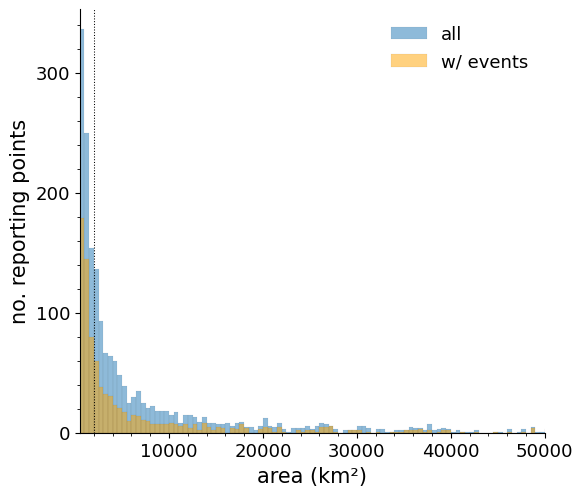

In [9]:
xmin = area_threshold
xmax = 500001#np.ceil(stations.area.max() / 500) * 500
bins = np.arange(xmin, xmax, 500).astype(int)

fig, ax = plt.subplots(figsize=(6, 5.5))
sns.histplot(stations.area, ax=ax, bins=bins, alpha=.5, label='all')
sns.histplot(stations[stations_w_events].area, ax=ax, alpha=.5, color='orange', bins=bins, label='w/ events')
ax.axvline(min_area, color='k', ls=':', lw=.75)
ax.set(xlabel='area (km²)', ylabel='no. reporting points', xlim=(xmin, 50000));
ax.xaxis.set_major_locator(MultipleLocator(10000))
ax.xaxis.set_minor_locator(MultipleLocator(2000))
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(20))
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False);

plt.savefig(path_out_root / f'area_distribution_{suffix}.jpg', dpi=300, bbox_inches='tight')

> ***Figure 1**. Distribution of the reporting points according to catchment area. The complete set of reporting points is shown in blue, and the subset of reporting points with observed flood events during the study period is shown in red. The balck, dotted line represents the minimum catchment area that will be used for the optimization of the notification criteria.*

**Map of number of "observed" events**

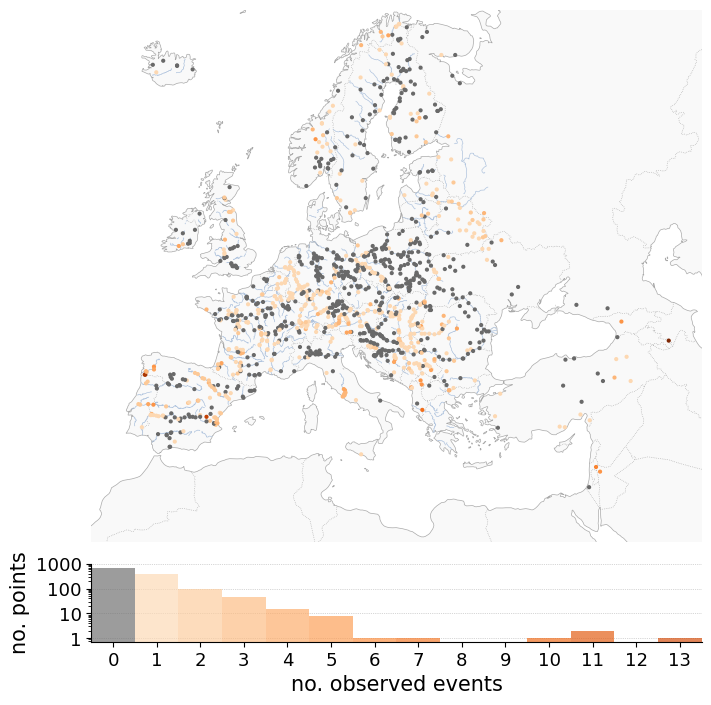

In [10]:
map_events(x=stations.loc[stations_optimize].X, 
           y=stations.loc[stations_optimize].Y, 
           events=stations.loc[stations_optimize][col_events],
           rivers=rivers,
           yscale='log',
           size=4, 
           save=path_out_root / f'map_observed_events_{suffix}.jpg')

> ***Figure 2**. Number of observed flood events during the study period.*

### 2.2 Hits, misses and false alarms

In [11]:
# import hits for each station
hits_stn = xr.open_mfdataset(f'{path_in}/*.nc', combine='nested', concat_dim='id')

# extract selected stations
stations = stations.loc[set(stations.index).intersection(hits_stn.id.data)]
hits_stn = hits_stn.sel(id=stations.index.to_list()).compute()

# convert to NaN lead times that can't be reached due to model limitations or persistence
hits_stn = limit_leadtime(hits_stn)

# subset of the 'hits' dataset with the stations selected for the optimization
stations_optimize = list(set(stations_optimize).intersection(hits_stn.id.data))
hits_opt = hits_stn.sel(id=stations_optimize).sum('id', skipna=False)

**Benchmark: current criteria**

In [12]:
# import hits for the benchmark
path_benchmark = Path(str(path_in).replace('NWP', 'COMB'))
hits_stn_current = xr.open_mfdataset(f'{path_benchmark}/*.nc', combine='nested', concat_dim='id')
hits_stn_current = hits_stn_current.sel(current_criteria).compute()

# convert to NaN lead times that can't be reached due to model limitations or persistence
hits_stn_current = limit_leadtime(hits_stn_current)

# subset of the 'hits' dataset with the stations selected for the optimization
hits_opt_current = hits_stn_current.sel(id=stations_optimize).sum('id', skipna=False)

## 3 Analysis

In this section I will compute the skill of the EFAS predictions in different ways. In all the following sections I will work with three metrics: $recall$, $precision$ and the $f_{beta}$ score. The three metrics are based in the contingency table of hits ($TP$ for true positives), false alarms ($FP$ for false positives) and misses ($FN$ for false negatives).

$$recall = \frac{TP}{TP + FN}$$
$$precision = \frac{TP}{TP + FP}$$
$$f_{beta} = \frac{(1 + \beta^2) \cdot TP}{(1 + \beta^2) \cdot TP + \beta^2 \cdot FN + FP}$$

### 3.1 Skill computation

In [13]:
# skill by station
skill_stn = hits2skill(hits_stn, beta=beta)

# skill dataset for optimizing criteria
skill_opt = hits2skill(hits_opt, beta=beta)

# export
skill_opt.to_netcdf(path_out / f'skill_{suffix}.nc')

**Benchmark: current criteria**

In [14]:
# skill of the benchmark
skill_opt_current = hits2skill(hits_opt_current, beta=beta)
skill_opt_current = skill_opt_current.where(skill_opt_current != 0, np.nan)

### 3.2 Analyse overall performance

In [15]:
# to simplify the plot, they will show only the following values of persistence and leadtime
persistences = skill_opt.persistence.data # ['1/1', '2/2', '3/3']

if min_leadtime is None:
    min_leadtime = int(skill_opt.leadtime.min().data)
if leadtime is None:
    leadtimes = [12, 36, 60, 84]
else:
    leadtimes = skill_opt.leadtime.data

In [16]:
# create a copy of 'skill_opt' to change acronyms
ds = skill_opt.copy()
ds['model'] = ds['model'].where(ds['model'] != 'EUD', 'HRES')
ds['model'] = ds['model'].where(ds['model'] != 'EUE', 'ENS')
ds = ds.sortby('model')

**Skill vs lead time for several probability thresholds**<br>
Only applicable for the daily lead times.

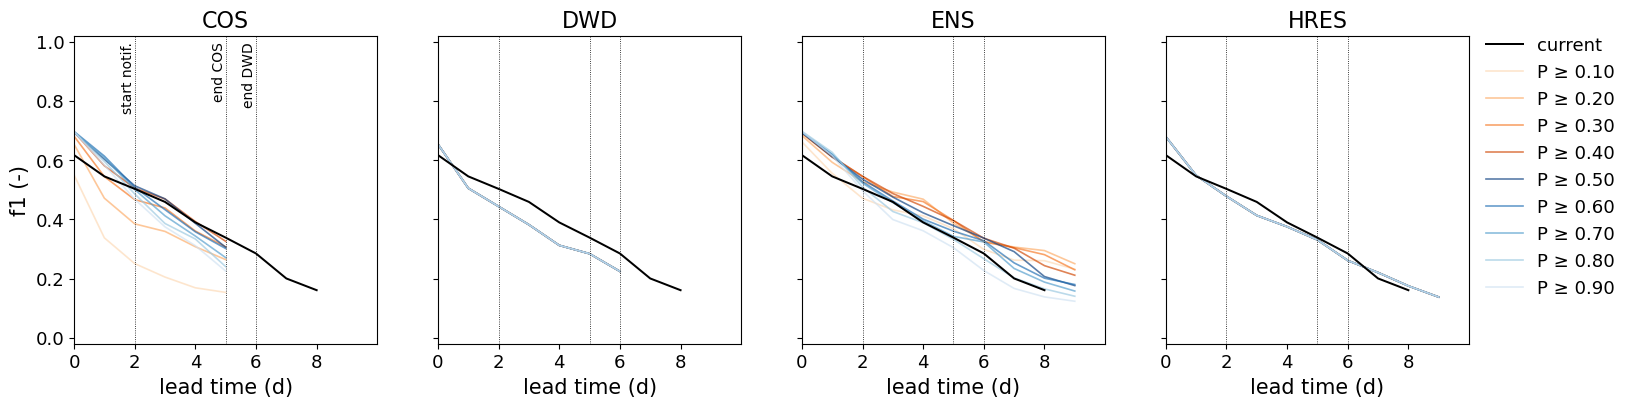

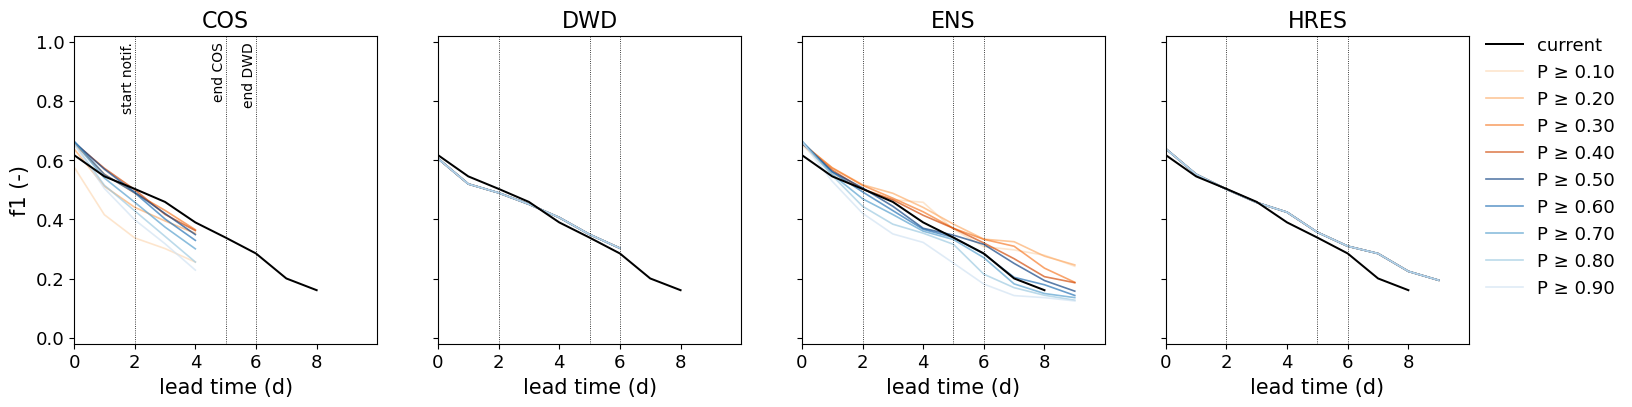

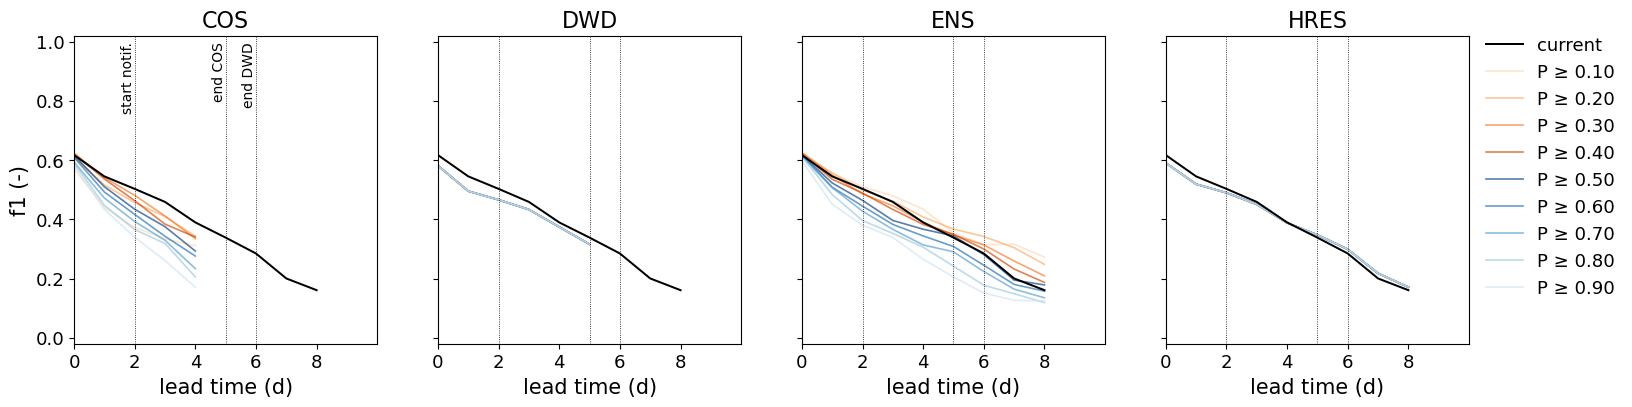

In [17]:
At = np.unique(np.diff(skill_opt.leadtime))
if (len(At) == 1) & (At[0] == 24):
    
    # define colour map
    OrBur = combine_cmaps('Oranges', 'Blues_r', lower1=.2, lower2=.05, name='OrBur')
    
    xmax = (skill_opt.leadtime.max().data + 12) / 24
    for pers in skill_opt.persistence.data:
        file = path_out / 'skill_probability_leadtime_{0}_NWP.pdf'.format(pers.replace('/', '-'))
        df = plot_skill_by_probability(ds,
                                       probability=np.round(np.arange(.1, .96, .1), 3),
                                       metric=metric,
                                       persistence=pers,
                                       coldim='model',
                                       benchmark=skill_opt_current,
                                       l=1,
                                       alpha=.666,
                                       xlabel='lead time (d)',
                                       cmap=OrBur,
                                       save=file)

**<font color='red'>This should be exported after the optimization has proven the best model!!!</font>**

In [18]:
# # export benchmark
# if (len(At) == 1) & (At[0] == 24):
#     skill_opt.sel(model='EUE', persistence='1/1', probability=.65).to_pandas().to_csv(path_ou / 'skill_EUE_benchmark_leadtime.csv')

**Skill vs probability for several persistences**<br>
Should this only be applicable to lead time ranges?

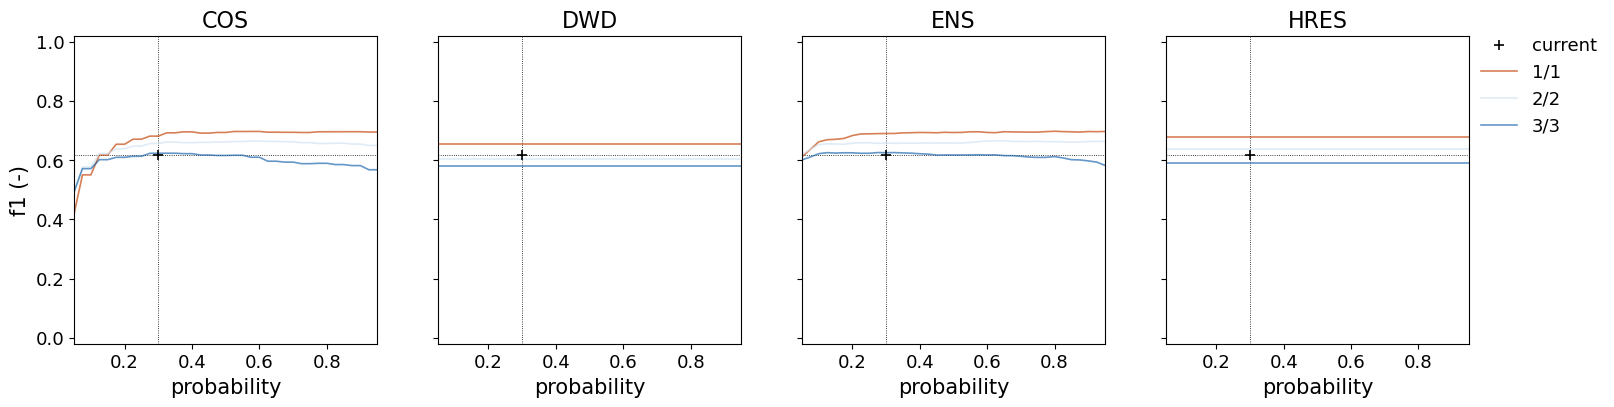

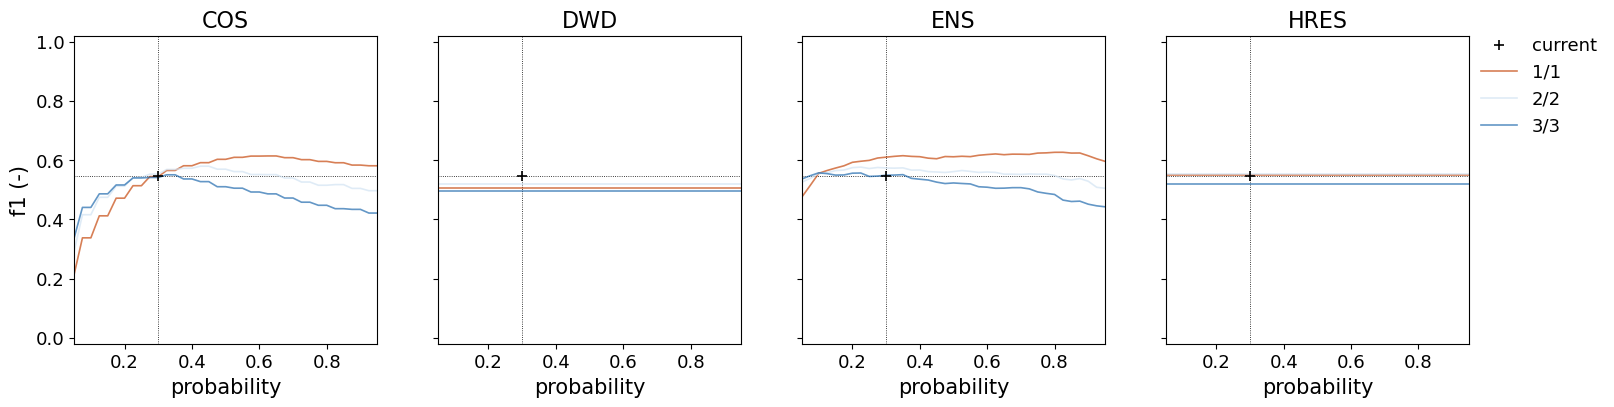

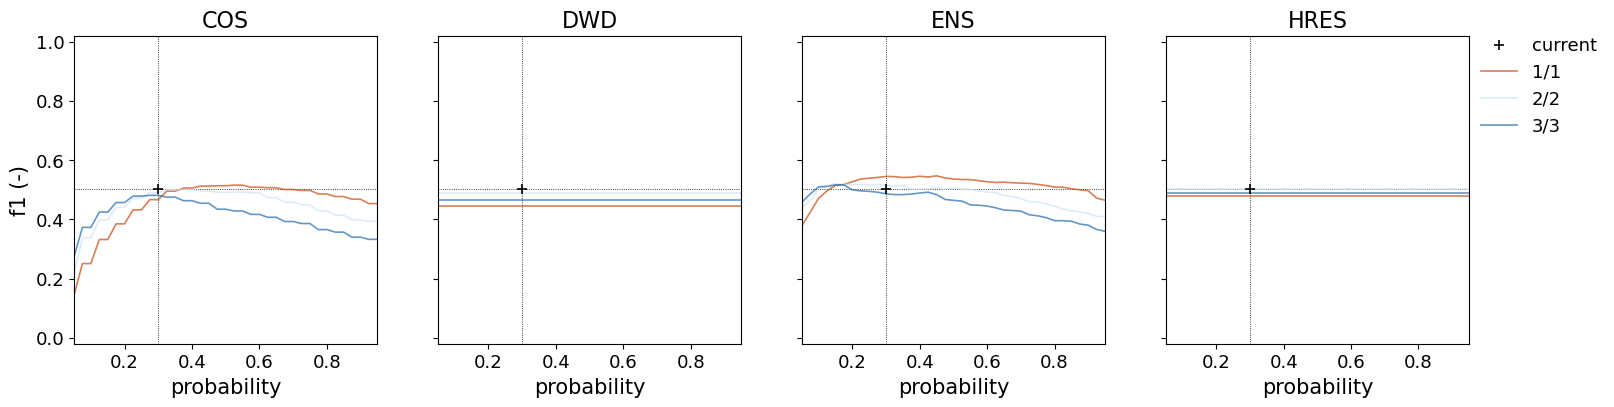

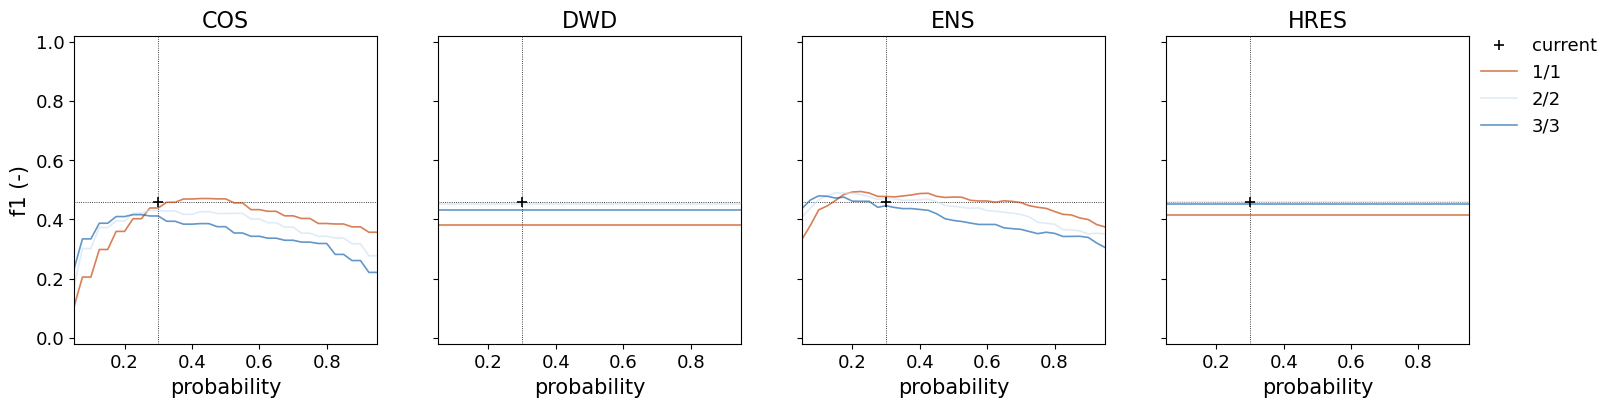

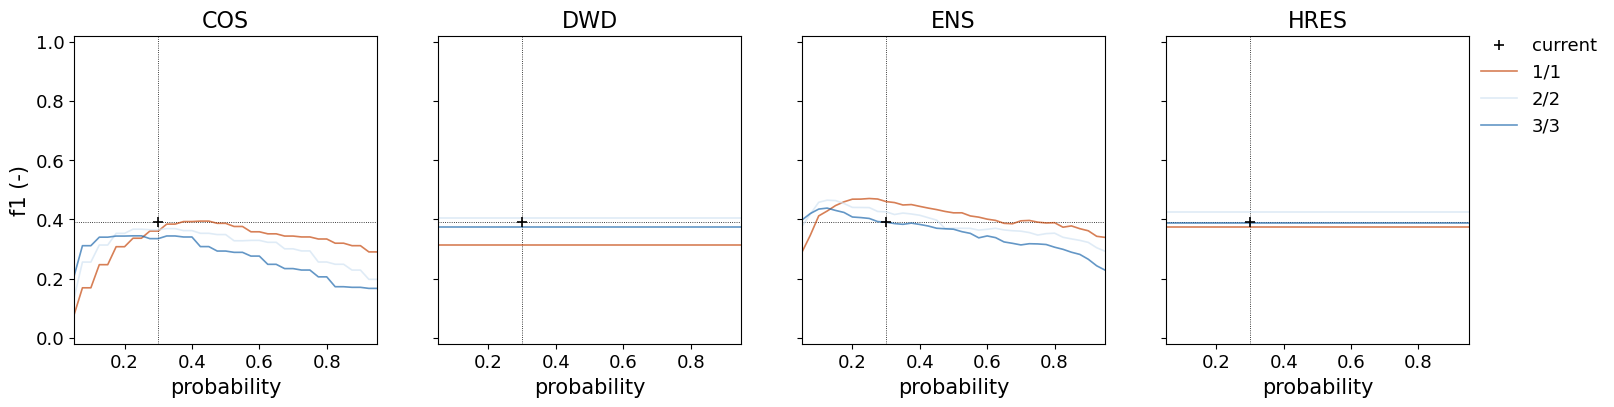

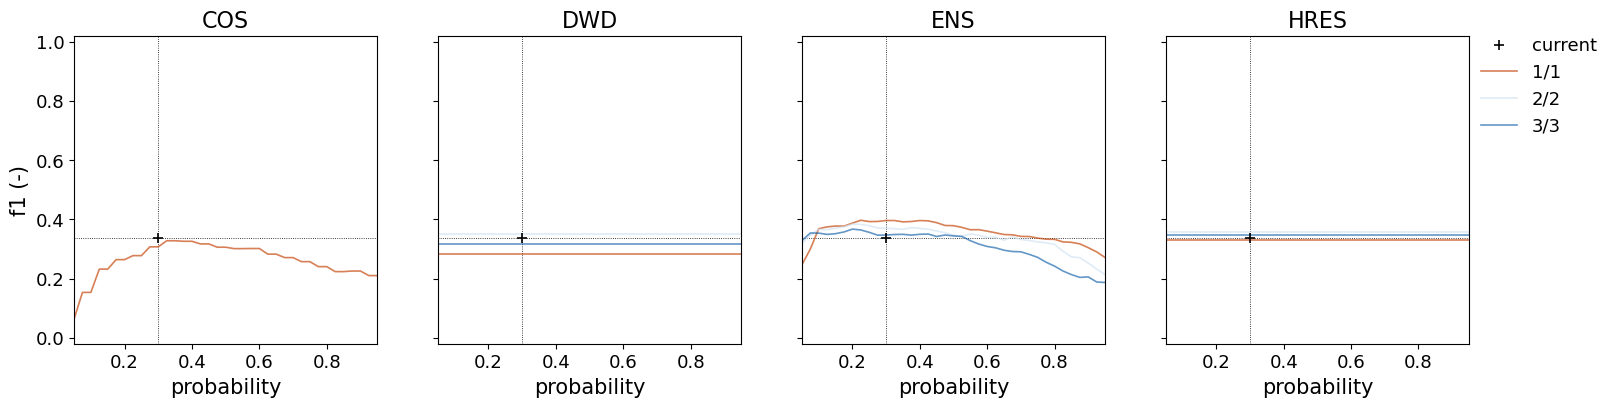

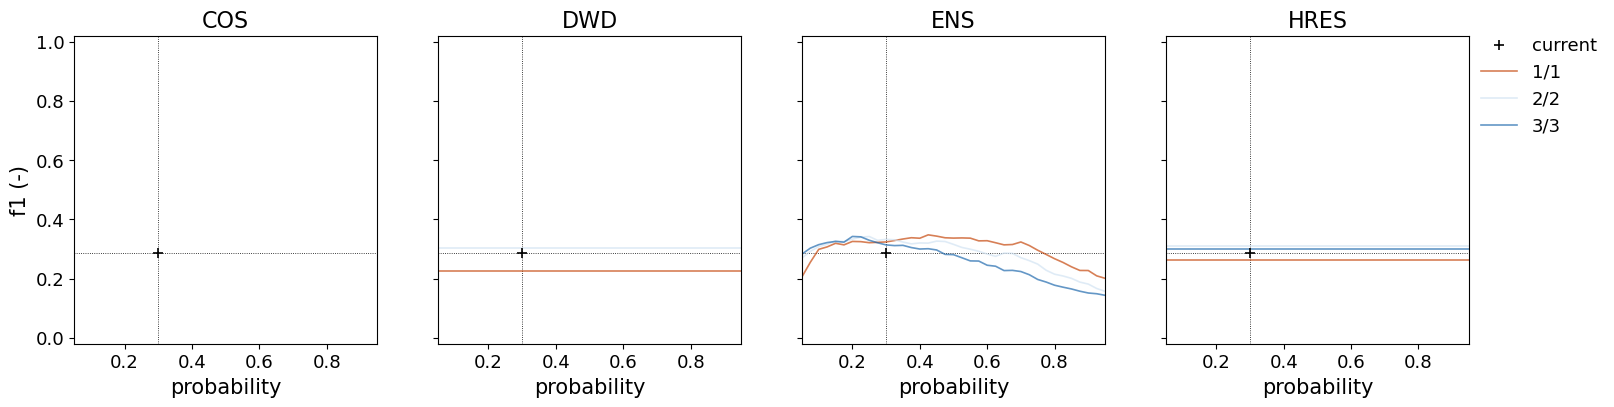

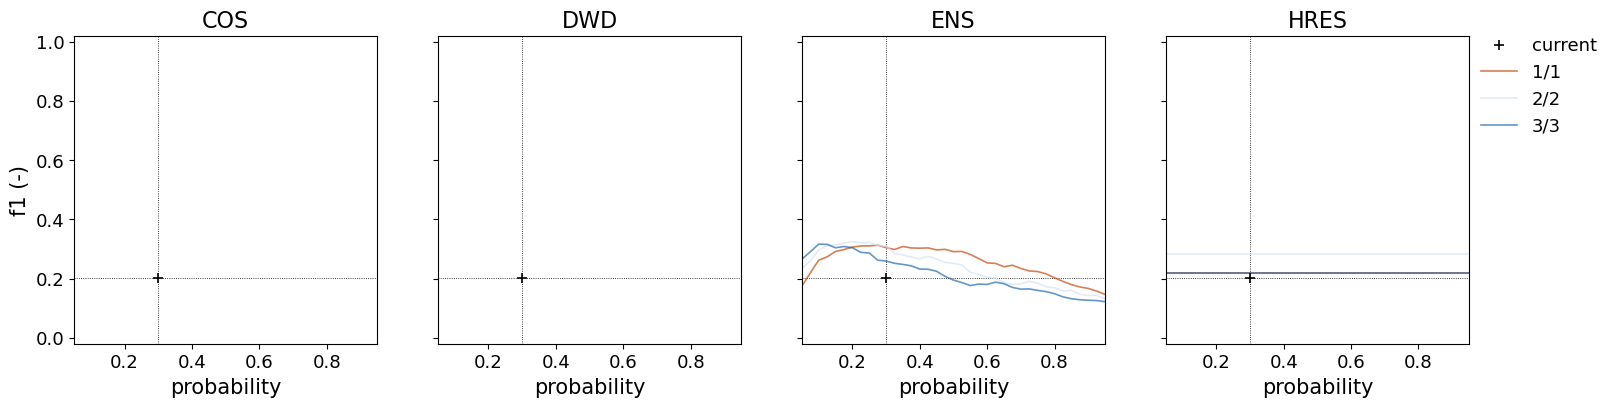

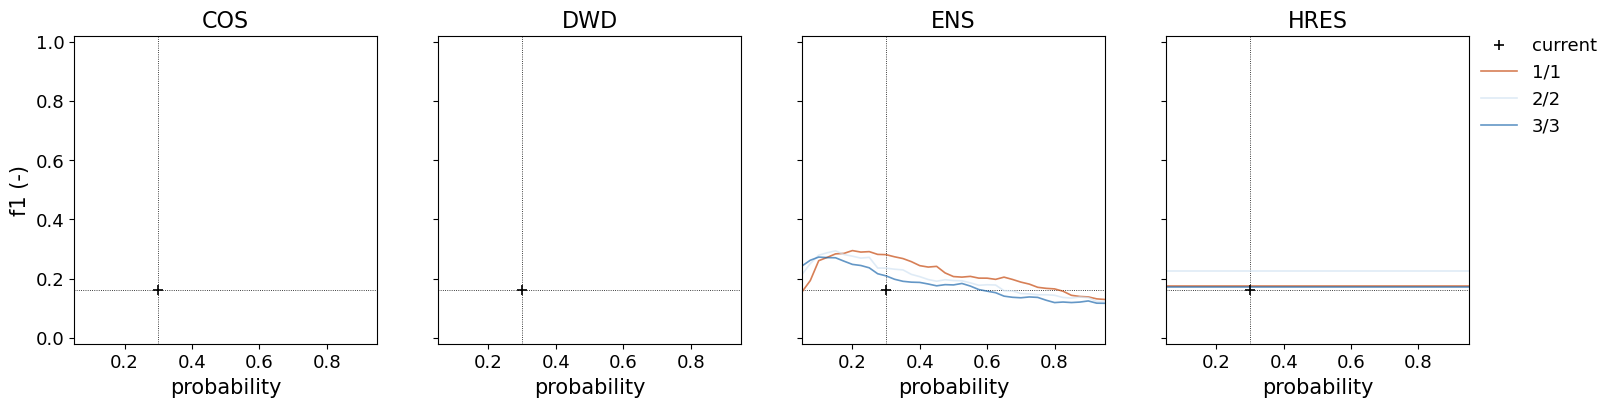

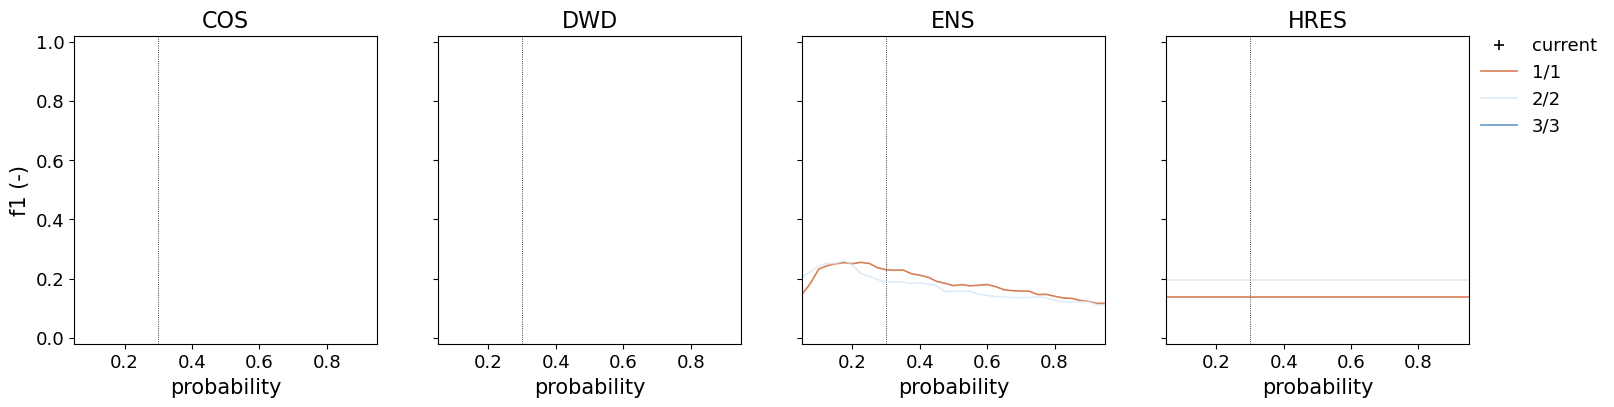

In [19]:
for lt in leadtimes:
    # define colour map
    OrrBu = combine_cmaps('Oranges_r', 'Blues', .2, .2, 'OrrBu')
    # plot
    plot_skill_by_persistence(ds.sel(leadtime=lt),
                              coldim='model',
                              metric=metric,
                              benchmark=skill_opt_current.sel(leadtime=lt),
                              cmap=OrrBu,
                              marker='+',
                              save=path_out / f'skill_persistence_probability_{lt:03}h.jpg')

**<font color='red'>This should be exported after the optimization has proven the best model!!!</font>**

In [20]:
# # export benchmark
# df = skill_opt.sel(leadtime=min_leadtime, model='EUE', persistence='1/1').to_pandas()
# df.to_csv(path_out / 'skill_EUE_benchmark_probability.csv')

#### 3.2.3 Optimize criteria

In this section we will derive a optimal set of notification criteria based on the target skill metric. To avoid overfitting, the sample of reporting points is first divided in a training and a test subset. This division is done in a stratified way after randomly shuflling the points, to keep the proportion of observed events in the subsets and avoid geographic biases, respectively.

To increase the robustness of the optimization, cross-validation is applied if the parameter `kfold` is set in the configuration file. In that case, `kfold` subsets of stations are generated, again in a stratified and random manner. The average skill over the subsets will be the data used to find the optimal criteria.

leadtime:  12 h
---------------

COS
...
probability:	0.375
persistence:	1/1
f1(train|test):	0.696|0.708

DWD
...
probability:	0.05
persistence:	1/1
f1(train|test):	0.664|0.657

EUD
...
probability:	0.05
persistence:	1/1
f1(train|test):	0.674|0.680

EUE
...
probability:	0.8
persistence:	1/1
f1(train|test):	0.693|0.696

leadtime:  36 h
---------------

COS
...
probability:	0.625
persistence:	1/1
f1(train|test):	0.628|0.617

DWD
...
probability:	0.05
persistence:	2/2
f1(train|test):	0.504|0.543

EUD
...
probability:	0.05
persistence:	2/2
f1(train|test):	0.552|0.540

EUE
...
probability:	0.8
persistence:	1/1
f1(train|test):	0.612|0.635

leadtime:  60 h
---------------

COS
...
probability:	0.525
persistence:	1/1
f1(train|test):	0.515|0.514

DWD
...
probability:	0.05
persistence:	2/2
f1(train|test):	0.496|0.486

EUD
...
probability:	0.05
persistence:	2/2
f1(train|test):	0.500|0.486

EUE
...
probability:	0.3
persistence:	1/1
f1(train|test):	0.561|0.510

leadtime:  84 h
---------------

COS


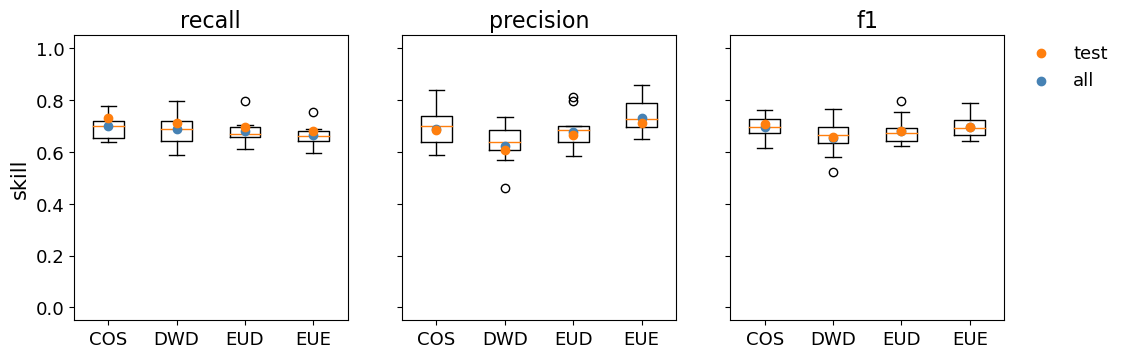

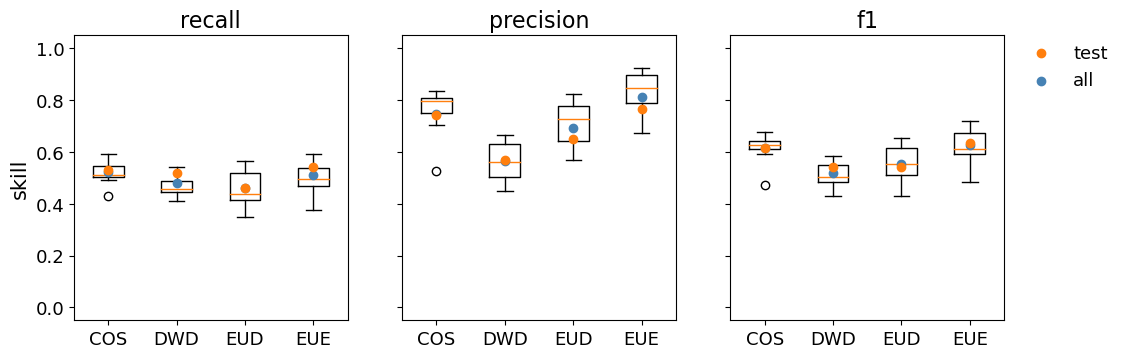

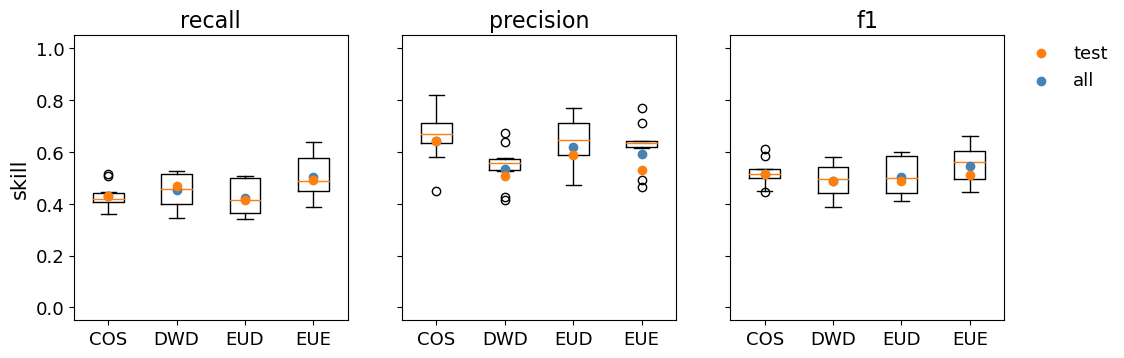

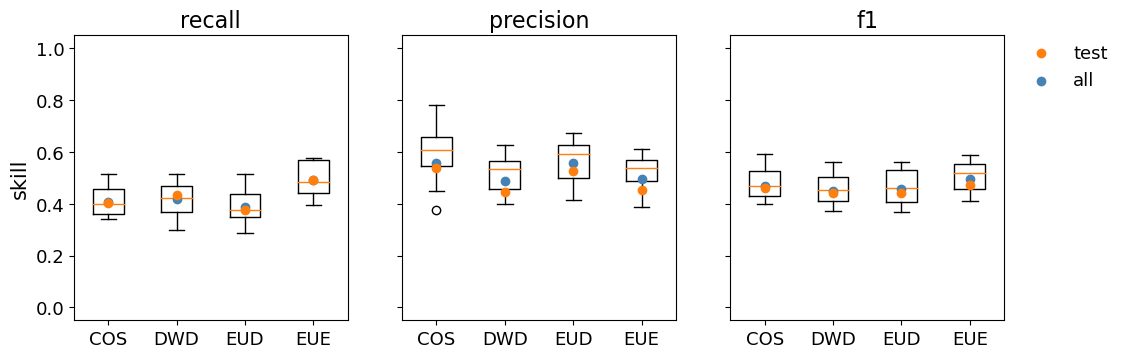

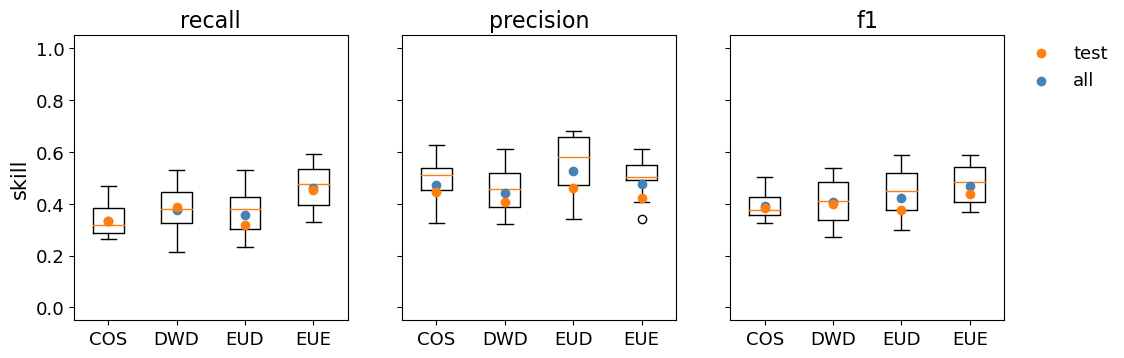

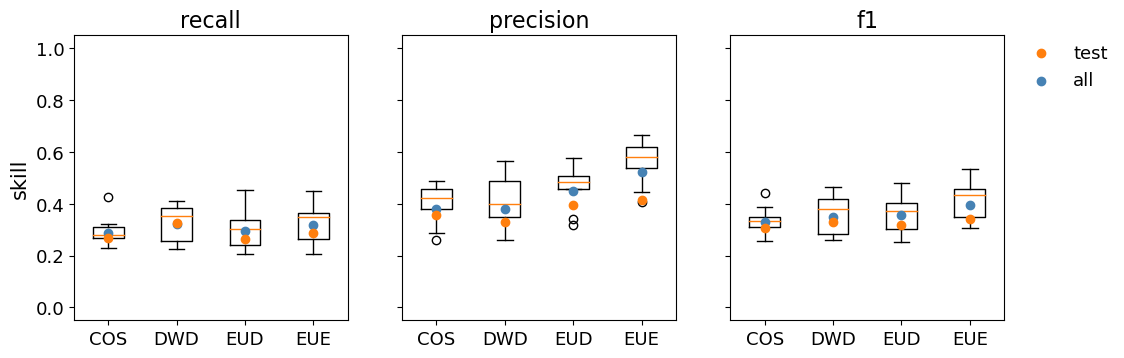

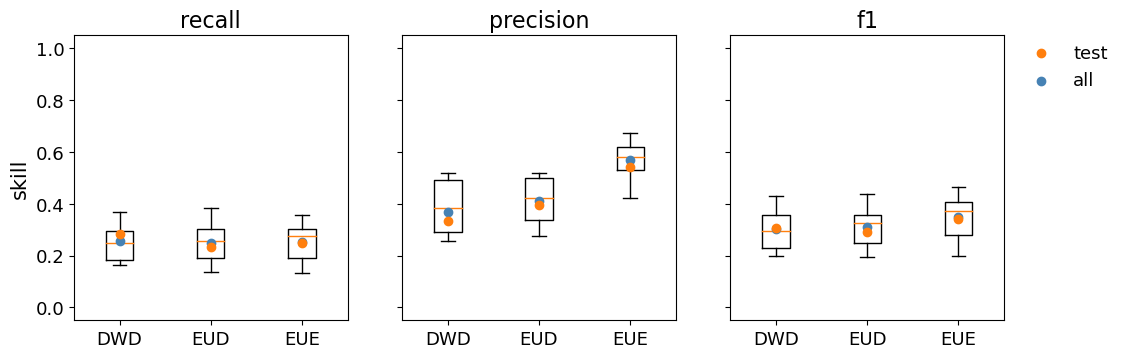

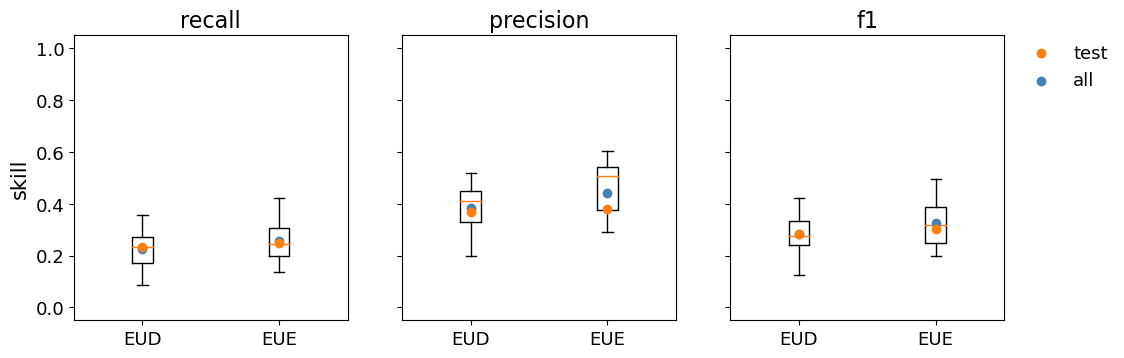

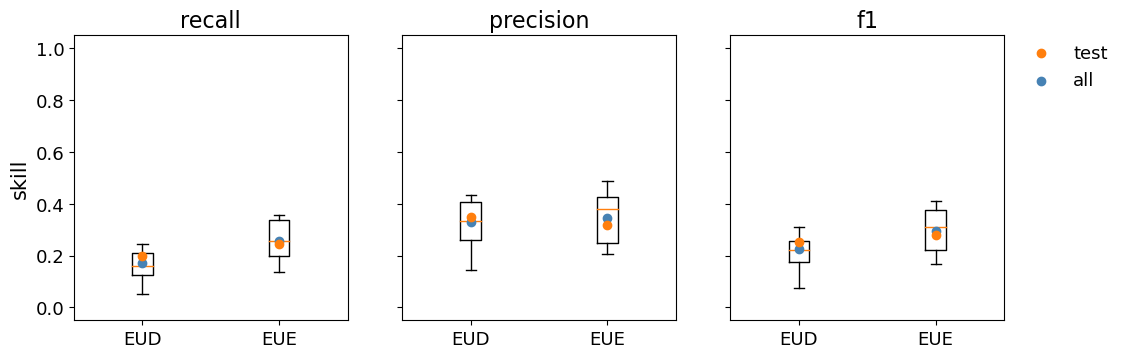

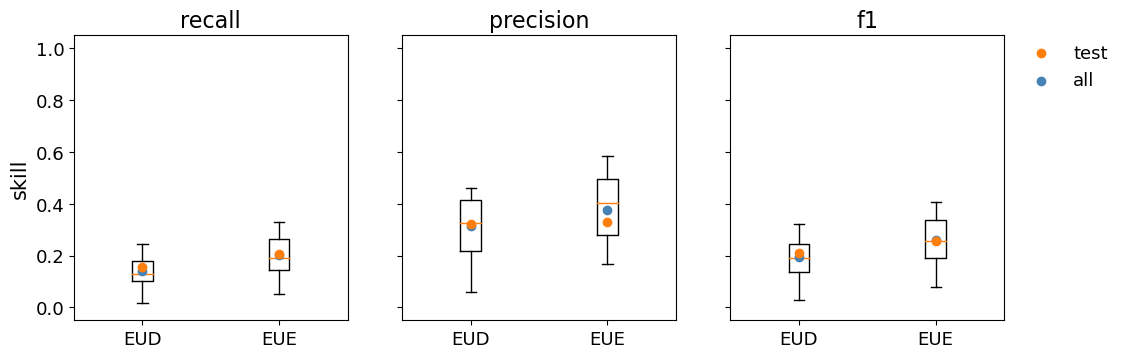

In [21]:
seed = 2

# divide stations in train and test samples
X = stations_optimize
y = stations.loc[X, col_events]
if stratify:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size, random_state=seed, shuffle=True, stratify=y)
else:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size, random_state=seed, shuffle=True)

best_criteria = {}
best_model = {}
for leadtime in hits_stn.leadtime.data:
    
    print(f'leadtime: {leadtime:>3} h')
    print('---------------\n')
    
    # subset of the 'hits' dataset for the training and test sets
    hits_train = hits_stn.sel(id=Xtrain, leadtime=leadtime)
    hits_test = hits_stn.sel(id=Xtest, leadtime=leadtime)

    # optimize the notification criteria
    if kfold is not None: # apply a cross-validation approach
        skill_train, best_criteria_lt = find_best_criteria_cv(hits_train,
                                                           stations.loc[Xtrain, col_events],
                                                           dims=list(min_spread),
                                                           kfold=kfold, train_size=train_size, random_state=seed, stratify=stratify,
                                                           beta=beta, tolerance=tolerance, min_spread=list(min_spread.values()))
    else:
        # skill of the training sample
        skill_train = hits2skill(hits_train.sum('id', skipna=True), beta=beta)
        # best criteria for each approach
        best_criteria_lt = find_best_criteria(skill_train, dims=list(min_spread),
                                           metric=metric, tolerance=tolerance, min_spread=list(min_spread.values()))

    # extract criteria as a dictionary
    dims = [var for var in best_criteria_lt if var not in ['recall', 'precision', metric]]
    best_criteria_lt = {model: {dim: best_criteria_lt.sel(model=model)[dim].data for dim in dims} for model in best_criteria_lt.model.data}
    for model in best_criteria_lt:
        best_criteria_lt[model]['model'] = model
    best_criteria[leadtime] = best_criteria_lt

    # skill of the train set for the optimized criteria
    skill_train = dict2da({model: skill_train.sel(sel) for model, sel in best_criteria_lt.items()}, dim='model')


    # skill of the test set for the optimized criteria
    skill_test = hits2skill(hits_test.sum('id', skipna=True), beta=beta)
    skill_test = dict2da({model: skill_test.sel(sel) for model, sel in best_criteria_lt.items()}, dim='model')

    # performance of the complete set of stations
    skill_all = dict2da({model: skill_opt.sel(leadtime=leadtime).sel(sel) for model, sel in best_criteria_lt.items()}, dim='model')

    # plot results of the optimization
    plot_skill_training(skill_train, skill_test, skill_all,
                        ylim=(-0.05, 1.05),
                        xdim='model',
                        save=path_out / f'skill_training_{suffix}_{leadtime:03}h.jpg')

    # print on screen results
    for model, dct in best_criteria_lt.items():
        print(model.replace('_', ' '))
        print('.' * len(model))
        for label, value in dct.items():
            if label == 'model':
                continue
            print(f'{label}:\t{value}')
        print('{0}(train|test):\t{1:.3f}|{2:.3f}\n'.format(metric,
                                                         skill_train.sel(model=model).median()[metric].data,
                                                         skill_test.sel(model=model).median()[metric].data))

    # model with the highest skill
    best_model[leadtime] = str(skill_test[metric].idxmax('model').data)

# export best criteria
file = path_out / f'optimized_criteria_{suffix}.pkl'
with open(file, 'wb') as f:
    pickle.dump(best_criteria, f)

> ***Figure 6**. Skill resulting of the otpimization process for each of the methods used to combine the meteorological forcings: 1D+1P, one deterministic and 1 probabilistic; MM, model mean; MW, member weighted; BW, Brier weihted; C, current operational criteria. If cross-validation was applied, the boxplots show the variance in the skill among the kfolds; if not, the black dots represent the skill of the training set. In either case, the orange dot represent the skill of the test set and the blue dots that of the complete set of reporting points.*

In [22]:
model = best_model[min_leadtime]

# export benchmark skill for the comparison against combination methods

# if (len(At) == 1) & (At[0] == 24):  
benchmark = pd.DataFrame(index=best_criteria.keys(),
                         columns=['probability', 'persistence', 'model', 'recall', 'precision', metric],
                         dtype=float)
benchmark.index.name = 'leadtime'
benchmark.model = model
for lt, dct in best_criteria.items():
    # extract criteria
    df = pd.Series(dct[model])
    benchmark.loc[lt, df.index] = df.values
    # extract skill
    df = skill_opt.sel(dct[model]).sel(leadtime=lt).to_pandas()
    benchmark.loc[lt, df.index] = df.values

# export as CSV
benchmark.to_csv(path_out / f'skill_{model}_benchmark_leadtime.csv')

KeyError: 'COS'

### 3.3 Analyse skill by reporting points

Once we have optimized the notification criteria for each approach, we will have a look to the distribution of the hits/misses/false alarms and the skill.

In [ ]:
# define colour map for the skill metrics
cmap_f1, norm_f1 = create_cmap(OrrBu, np.arange(0, 1.01, 0.05), name='skill')

# map hits/misses/false alarmas and performance for each of the total probability approaches
s = 2
alpha = .5
for leadtime in [min_leadtime]:#leadtimes:
    for key, criteria in best_criteria[leadtime].items():

        title = '{0}\nprobability = {1}\npersistence = {2}'.format(key.replace('_', ' '), criteria['probability'], criteria['persistence'])

        # extract TP, FN, FP for this approach
        cols = ['TP', 'FN', 'FP']
        stations[cols] = hits_stn.sel(leadtime=leadtime).sel(criteria).to_pandas()[cols]

        # plot maps of TP, FN, FP
        map_hits(stations.loc[stations_optimize],
                 cols=['TP', 'FN', 'FP'],
                 mask=stations_w_events,
                 s=s, alpha=alpha,
                 title=title,
                 save=path_out / f'hits_maps_reporting_points_{suffix}_{key}_{leadtime:03}h.jpg')

        # compute metrics
        stations['recall'] = stations.TP / (stations.TP + stations.FN)
        stations['precision'] = stations.TP / (stations.TP + stations.FP)
        stations[metric] = (1 +  beta**2) * stations.TP / ((1 +  beta**2) * stations.TP + beta**2 * stations.FN + stations.FP)

        # plot maps of performance
        map_skill(stations.loc[stations_optimize],
                  cols=['recall', 'precision', metric],
                  bins=50,
                  cmap=cmap_f1, norm=norm_f1,
                  s=s, alpha=alpha,
                  title=title,
                  save=path_out / f'skill_maps_reporting_points_{suffix}_{key}_{leadtime:03}h.jpg')
        
stations.drop(['TP', 'FN', 'FP', 'recall', 'precision', metric], axis=1, inplace=True)

> ***Figure 7**. Maps of hits, misses and false alarms for the criteria otimized for each approach. The colour scale changes depending on the variable; orange (darker orange) means worse values, whereas blue (darker blue) better values. In the case of hits (TP) and misses (FN) a mask has been applied to remove reporting points with no observed events (gray points), since none of these variables can be computed if there are no observations to predict or miss. The histograms at the bottom show the distributions of hits, misses and false alarms over the whole domain.*

> ***Figure 8**. Maps of skill for the criteria otimized for each approach. Orange values represent poor skill, whereas blue values high skill; gray dots represent points for which the metric can not be computed. The histograms at the bottom show the distribution of skill over the whole domain.*

In [ ]:
hits_stn_best = hits_stn.sel(leadtime=min_leadtime).sel(best_criteria[min_leadtime][best_model[min_leadtime]])
for var, da in hits_stn_best.items():
    stations[var] = da.to_pandas()
stations['recall'] = stations.TP / (stations.TP + stations.FN)
stations['precision'] = stations.TP / (stations.TP + stations.FP)
stations[metric] = (1 +  beta**2) * stations.TP / ((1 +  beta**2) * stations.TP + beta**2 * stations.FN + stations.FP)

# export station including skill
stations.to_parquet(path_out / str(file_stations).split('\\')[-1])

**Röbber diagram**<br>
evolution of skill with lead time

In [ ]:
# dictionary of optimal performances
PR = {NWP: pd.DataFrame(index=best_criteria.keys(), columns=['precision', 'recall']) for NWP in models.keys()}
for lt, dct in best_criteria.items():
    for NWP, criteria in dct.items():
        aux = skill_opt.sel(criteria).sel(leadtime=lt).to_pandas()
        PR[NWP].loc[lt,:] = aux[['precision', 'recall']]

# plot
BurOr = combine_cmaps('Blues_r', 'Oranges', .2, .05)
colors_models = ListedColormap(BurOr(np.linspace(0, 1, 4))).colors

fig, ax = roebber_diagram(metric='fscore', beta=beta)
    
for key, color in zip(['EUE', 'COS', 'EUD', 'DWD'], colors_models):
    df = PR[key]
    ax.plot(df.precision, df.recall, color=color, lw=1.2, label=key)
    ax.scatter(*df.loc[min_leadtime,:], marker='o', s=20, color=color, zorder=9)

ax.scatter(1.2, 1.2, marker='o', s=20, color='gray', label='LT = 2 d')
fig.legend(frameon=False, bbox_to_anchor=[1.08, .50, .2, .4]);

plt.savefig(path_out / f'roebber_diagram_{suffix}.jpg', dpi=300, bbox_inches='tight');

### 3.4 Analyse skill by catchment area

So far we have analyzed only stations with a catchment area larger or equal than a fixed value (2000 km²). Also, in the optimization of the notification criteria this minimum catchment area was fixed.

In this section we will analyze how results change according to the catchment area. First, we will see the evolution of skill over catchment area for the notification criteria optimized for a minimum catchment area. Later, we will derive a new optimization criteria in which the probability threshold varies according to catchment area. This derivation is repeated for every approach, and the persistence criterion is fixed for each approach to the value optimized in the previous sections.

In [ ]:
# define an array of catchment area thresholds
area_max = np.ceil(stations.area.max() / 500) * 500
areas = define_area_ranges(500, area_max, scale='semilog')

# no. stations and events by catchment area threshold
stations_area = summarize_by_area(stations.area, stations[col_events], areas)

# hits and skill by catchment area
areas = stations_area[stations_area.n_events_obs > 0].index.to_list()
hits_area = hits_by_area(hits_stn.sel(leadtime=leadtimes), stations.area, areas)
skill_area = hits2skill(hits_area, beta=beta)
skill_area = skill_area.dropna('area', how='all')

In [ ]:
criteria_area = {}
for area in tqdm_notebook(areas):
        
    # divide stations in train and test samples
    X = stations.loc[stations.area >= area].index
    if len(X) == 0:
        break
    y = stations.loc[X, col_events]
    if stratify:
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size, random_state=seed, shuffle=True, stratify=y)
    else:
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size, random_state=seed, shuffle=True)

    # subset of the 'hits' dataset for the training and test sets
    hits_train = hits_stn.sel(id=Xtrain, leadtime=leadtimes)

    # optimize the notification criteria
    try:
        if kfold is not None: # apply a cross-validation approach
            skill_train, criteria = find_best_criteria_cv(hits_train,
                                                          stations.loc[Xtrain, col_events],
                                                          dims='probability',
                                                          kfold=kfold, train_size=train_size, random_state=seed, stratify=stratify,
                                                          beta=beta, tolerance=tolerance, min_spread=min_spread['probability'])
        else:
            # skill of the training sample
            skill_train = hits2skill(hits_train.sum('id', skipna=True), beta=beta)
            # best criteria for each approach
            criteria = find_best_criteria(skill_train, dims='probability',
                                          metric=metric, tolerance=tolerance, min_spread=min_spread['probability'])

        criteria_area[area] = criteria['probability']
            
    except:
        continue
        
criteria_area = dict2da(criteria_area, dim='area')

#### 3.4.1 Stations and events according to catchment area

In [ ]:
lw = 1
alpha = 1.
c1 = mpl.cm.get_cmap('Oranges', 128)(.66)
c2 = mpl.cm.get_cmap('Blues', 128)(.66)

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(stations_area.index, stations_area.n_stations, alpha=alpha, c=c1, lw=lw, label='points', zorder=2)
ax.plot(stations_area.index, stations_area.n_events_obs, alpha=alpha, c=c2, lw=lw, label='events', zorder=1)
ax.axvline(x=min_area, ls=':', lw=.5, color='k', zorder=0)
ax.text(2000, 0, 'current limit', va='bottom', ha='right', rotation=90)#, fontsize=12)
ymin, ymax = 0, np.ceil(stations_area.max().max() / 1000) * 1000
yticks = np.arange(ymin, ymax * 1.02, 500).astype(int)
ax.set(xlabel='area ≥ (km²)',
       xscale='log',
       xlim=(500, area_max),
       ylim=(ymin - ymax * .02, ymax * 1.02),
       ylabel='count (-)',
       yticks=yticks)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False, loc=1);

plt.savefig(path_out_root / f'points_observedEvents_vs_area_{suffix}.jpg', dpi=300, bbox_inches='tight');

> ***Figure 9**. Number of reporting points (orange) and observed events (blue) by catchment area.*

#### 3.4.2 Current vs optimized criteria

**Hits, misses and false alarms**

In [ ]:
for lt in [min_leadtime]:#leadtimes:
    plot_hits_by_variable(hits_area.sel(leadtime=lt),
                          optimal_criteria=best_criteria[lt],
                          variable='area',
                          coldim='model',
                          reference=min_area,
                          current_criteria=best_criteria[lt]['EUE'],
                          xscale='log', xlabel='area ≥ (km²)', xlim=(criteria_area.area.min(), criteria_area.area.max()),
                          loc_legend=[.87, .8, .2, .1],
                          save=path_out / f'hits_vs_area_{suffix}_{lt:03}h.jpg')

> ***Figure 10**. Evolution of hits, misses and false alarms with catchment area threshold. Each plot represents a different approach to combine the meteorological forcings. The primary Y axis is normalized by the number of observed events to allow for comparison; the secondary Y axis indicates the probability threshold. The continuous lines are the hits, whereas the shadows are the false alarms; the difference between the reference line ($\frac{x}{obs}=1$) and the hits are the misses. The dotted lines are the probability thresholds. Black objects represent the current operational criteria and blue ones the criteria optimized for a fixed area threshold (represented by a vertical, solid, black line).*

**Skill**

<font color='red'>**The benchmark should be the current approach**</font>

In [ ]:
for lt in leadtimes:
    plot_skill_by_variable(skill_area.sel(leadtime=lt),
                           optimal_criteria=best_criteria[lt],
                           variable='area',
                           coldim='model',
                           reference=min_area,
                           metric=metric,
                           current_criteria=best_criteria[lt]['EUE'],
                           xscale='log', xlabel='area ≥ (km²)', loc_text=3, loc_legend=[.87, .8, .2, .1],
                           shades=False,
                           save=path_out / f'skill_vs_area_{suffix}_{lt:03}h.jpg')

> ***Figure 11**. Evolution of skill with catchment area threshold. Each plot represents a different approach in which the meteorological forcings are combined. The primary Y axis indicates skill, and the secondary Y axis indicates the probability threshold. The continuous lines are the target skill score ($f_{0.8}$), and the shadows represent the difference between $precision$ and $recall$. The dotted lines are the probability thresholds. Black objects represent the current operational criteria and blue ones the criteria optimized for a fixed area threshold (represented by the vertical, solid, black line).*

In [ ]:
colors = {'EUE': colors_models[0],
          'COS': colors_models[1],
          'EUD': colors_models[2],
          'DWD': colors_models[3]}

for lt in leadtimes:
    optimal_criteria = {key: best_criteria[lt][key] for key in ['EUE', 'COS', 'EUD', 'DWD'] if key in best_criteria[lt]}
    plot_skill_by_area(skill_area.sel(leadtime=lt), 
                       optimal_criteria=optimal_criteria,
                       reference=min_area,
                       metric=metric,
                       xscale='log', xlabel='area ≥ (km²)', xlim=(skill_area.area.data.min(), 3e5),
                       colors=colors,
                       save=path_out / f'skill_vs_area_{suffix}_{lt:03}h.jpg')

#### 3.4.3 Fixed criteria vs area optimized criteria

In the previous section we have analyzed how the skill of the system varies over catchment area for a fixed value of the probability threshold. But, what if we tune the probability threshold according to catchment area? Would it improved the skill of the system?

**Hits, misses and false alarms**

In [ ]:
for lt in [min_leadtime]:#leadtimes:
    plot_hits_by_variable(hits_area.sel(leadtime=lt),
                          optimal_criteria=best_criteria[lt],
                          variable='area',
                          coldim='model',
                          reference=min_area,
                          optimized_criteria=criteria_area.sel(leadtime=lt),
                          xscale='log', xlabel='area ≥ (km²)', xlim=(criteria_area.area.min(), criteria_area.area.max()),
                          loc_text=1, loc_legend=[.9, .8, .2, .1],
                          save=path_out / f'hits_vs_area_varying_probability_{suffix}_{lt:03}h.jpg', )

> ***Figure 12**. Evolution of hits, misses and false alarms with catchment area threshold. Each plot represents a different approach to combine the meteorological forcings. The primary Y axis is normalized by the number of observed events to allow for comparison; the secondary Y axis indicates the probability threshold. The continuous lines are the hits, the shadows are the false alarms, and the difference between the reference line ($\frac{x}{obs}=1$) and the hits are the misses. The dotted lines show the probability threshold. Blue objects are the results for the criteria optimized for a fixed area threshold (represented by a vertical, solid, black line), and orange objects those for the criteria optimized for every area threshold.*

**Skill**

In [ ]:
for lt in [min_leadtime]:#leadtimes:
    plot_skill_by_variable(skill_area.sel(leadtime=lt),
                           optimal_criteria=best_criteria[lt],
                           variable='area',
                           coldim='model',
                           reference=min_area,
                           metric=metric,
                           optimized_criteria=criteria_area.sel(leadtime=lt),
                           xscale='log', xlabel='area ≥ (km²)', loc_text=2, loc_legend=[.9, .8, .2, .1],
                           save=path_out / f'skill_vs_area_varying_probability_{suffix}_{lt:03}h.jpg')

> ***Figure 13**. Evolution of skill with catchment area threshold. Each plot represents a different approach in which the meteorological forcings are combined. The primary Y axis indicates skill, and the secondary Y axis indicates the probability threshold. The continuous lines are the target skill score ($f_{0.8}$), and the shadows represent the difference between $precision$ and $recall$. The dotted lines show the probability threshold. Blue objects are the results for the criteria optimized for a fixed area threshold (represented by a vertical, solid, black line), and orange objects those for the criteria optimized for every area threshold.*